## 1. Load library

In [1]:
# basic library
import pandas as pd
import random
import os
import numpy as np
import warnings
import time
import datetime
from datetime import datetime
# option library
warnings.filterwarnings('ignore')

# preprocessing library
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# model library
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold,StratifiedKFold
import lightgbm as lgb
from catboost import CatBoostClassifier

# metrics library(평가지표)
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report

# validation library(검증)
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

# optuna library
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split

In [2]:
# Seed 고정
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) 

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

## 2. Load Data

In [4]:
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')

* Columns
 - Y_class : 제품 품질 상태(Target)
   + 0 : 적정 기준 미달 (부적합)
   + 1 : 적합
   + 2 : 적정 기준 초과 (부적합)
 - Y_Quality : 제품 품질 관련 정량적 수치
 - TIMESTAMP : 제품이 공정에 들어간 시각
 - LINE : 제품이 들어간 공정 LINE 종류  ('T050304','T050307','T100304','T010306','T010305')
 - PRODUCT_CODE : 제품의 CODE 번호('A_31', 'T_31', 'O_31')
 - X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

## 3. 데이터 확인

In [5]:
# train데이터 
train_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#test 데이터
test_df

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,TEST_305,2022-11-05 11:18,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306,TEST_306,2022-11-05 16:39,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,TEST_307,2022-11-05 16:47,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,TEST_308,2022-11-05 20:53,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> #### 데이터 공정라인과 제품번호 확인

In [7]:
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    print(np.unique(train_df[i]))

['T010305' 'T010306' 'T050304' 'T050307' 'T100304' 'T100306']
['A_31' 'O_31' 'T_31']


In [8]:
train_df[["TIMESTAMP",'LINE']]

,TIMESTAMP,LINE
0,2022-06-13 5:14,T050304
1,2022-06-13 5:22,T050307
2,2022-06-13 5:30,T050304
3,2022-06-13 5:39,T050307
4,2022-06-13 5:47,T050304
...,...,...
593,2022-09-08 14:30,T100306
594,2022-09-08 22:38,T050304
595,2022-09-08 22:47,T050304
596,2022-09-08 14:38,T100304


In [9]:
train_df['TIMESTAMP'][:]

0       2022-06-13 5:14
1       2022-06-13 5:22
2       2022-06-13 5:30
3       2022-06-13 5:39
4       2022-06-13 5:47
             ...       
593    2022-09-08 14:30
594    2022-09-08 22:38
595    2022-09-08 22:47
596    2022-09-08 14:38
597    2022-09-08 14:46
Name: TIMESTAMP, Length: 598, dtype: object

Text(0.5, 1.0, 'Y_Class Countplot')

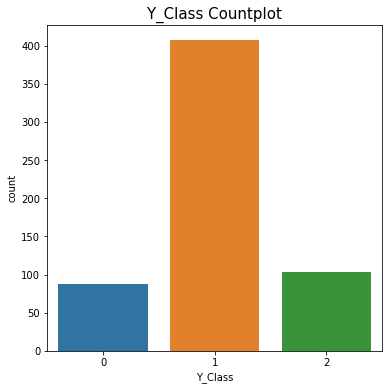

In [10]:
plt.figure(figsize=(6,6))
sns.countplot(x='Y_Class',data=train_df)
plt.xlabel('Y_Class',fontsize=10)
plt.title('Y_Class Countplot',fontsize=15)

Text(0.5, 1.0, 'Y_Class Countplot')

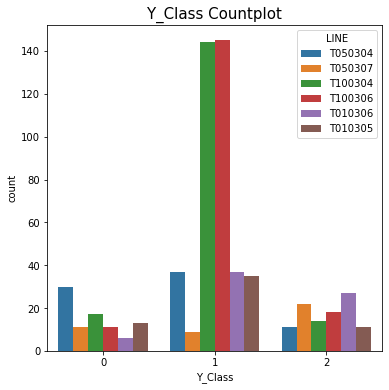

In [11]:
plt.figure(figsize=(6,6))
sns.countplot(x='Y_Class',data=train_df, hue = qual_col[0])
plt.xlabel('Y_Class',fontsize=10)
plt.title('Y_Class Countplot',fontsize=15)

Text(0.5, 1.0, 'Y_Class Countplot')

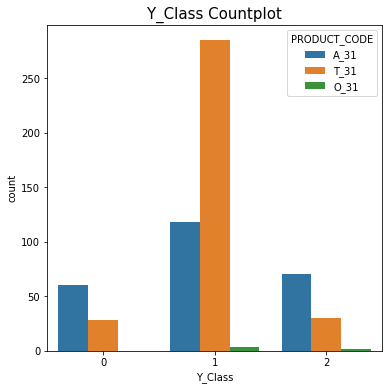

In [12]:
plt.figure(figsize=(6,6))
sns.countplot(x='Y_Class',data=train_df, hue = qual_col[1])
plt.xlabel('Y_Class',fontsize=10)
plt.title('Y_Class Countplot',fontsize=15)

In [13]:
train_df['PROCESS'] = train_df['LINE']+'-'+train_df['PRODUCT_CODE']

In [14]:
test_df['PROCESS'] = test_df['LINE']+'-'+test_df['PRODUCT_CODE']

Text(0.5, 1.0, 'Y_Class Countplot')

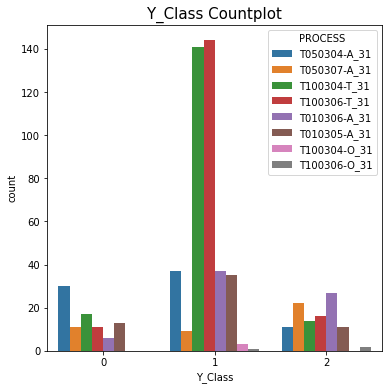

In [15]:
plt.figure(figsize=(6,6))
sns.countplot(x='Y_Class',data=train_df, hue = 'PROCESS')
plt.xlabel('Y_Class',fontsize=10)
plt.title('Y_Class Countplot',fontsize=15)

In [16]:
test_df['TIMESTAMP'] = pd.to_datetime(test_df['TIMESTAMP'])
train_df['TIMESTAMP'] = pd.to_datetime(train_df['TIMESTAMP'])

In [17]:
test_df['minute']=test_df['TIMESTAMP'].dt.minute
train_df['minute']=train_df['TIMESTAMP'].dt.minute

In [18]:
test_df['hour']=test_df['TIMESTAMP'].dt.hour
train_df['hour']=train_df['TIMESTAMP'].dt.hour

In [19]:
test_df['day']=test_df['TIMESTAMP'].dt.day
train_df['day']=train_df['TIMESTAMP'].dt.day

In [20]:
test_df['day'].unique()

array([ 9, 10, 11, 17, 20, 22, 23, 24, 25, 26, 27, 28,  1,  2,  3,  7,  8,
       12, 13, 14, 15, 16, 18, 19, 21, 29, 30, 31,  4,  5], dtype=int64)

In [21]:
display(train_df, test_df)

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,PROCESS,minute,hour,day
0,TRAIN_000,1,0.533433,2022-06-13 05:14:00,T050304,A_31,NaN,NaN,NaN,NaN,...,77.77,NaN,NaN,NaN,NaN,NaN,T050304-A_31,14,5,13
1,TRAIN_001,2,0.541819,2022-06-13 05:22:00,T050307,A_31,NaN,NaN,NaN,NaN,...,72.55,NaN,NaN,NaN,NaN,NaN,T050307-A_31,22,5,13
2,TRAIN_002,1,0.531267,2022-06-13 05:30:00,T050304,A_31,NaN,NaN,NaN,NaN,...,78.35,NaN,NaN,NaN,NaN,NaN,T050304-A_31,30,5,13
3,TRAIN_003,2,0.537325,2022-06-13 05:39:00,T050307,A_31,NaN,NaN,NaN,NaN,...,71.78,NaN,NaN,NaN,NaN,NaN,T050307-A_31,39,5,13
4,TRAIN_004,1,0.531590,2022-06-13 05:47:00,T050304,A_31,NaN,NaN,NaN,NaN,...,76.97,NaN,NaN,NaN,NaN,NaN,T050304-A_31,47,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30:00,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100306-T_31,30,14,8
594,TRAIN_594,0,0.524022,2022-09-08 22:38:00,T050304,A_31,NaN,NaN,NaN,NaN,...,66.49,1.0,NaN,NaN,NaN,NaN,T050304-A_31,38,22,8
595,TRAIN_595,0,0.521289,2022-09-08 22:47:00,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,T050304-A_31,47,22,8
596,TRAIN_596,1,0.531375,2022-09-08 14:38:00,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100304-O_31,38,14,8


,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,PROCESS,minute,hour,day
0,TEST_000,2022-09-09 02:01:00,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100306-T_31,1,2,9
1,TEST_001,2022-09-09 02:09:00,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100304-T_31,9,2,9
2,TEST_002,2022-09-09 08:42:00,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100304-T_31,42,8,9
3,TEST_003,2022-09-09 10:56:00,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,T010305-A_31,56,10,9
4,TEST_004,2022-09-09 11:04:00,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,T010306-A_31,4,11,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,TEST_305,2022-11-05 11:18:00,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100306-T_31,18,11,5
306,TEST_306,2022-11-05 16:39:00,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100304-T_31,39,16,5
307,TEST_307,2022-11-05 16:47:00,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100306-T_31,47,16,5
308,TEST_308,2022-11-05 20:53:00,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100306-T_31,53,20,5


## 4. Data PreProcessing

In [22]:
# test data와 train data 에서 분류할 colums LINE,PRODUCT_CODE,X데이터만 남김
test_x = test_df.drop(columns = ['PRODUCT_ID','TIMESTAMP'])
train_x = train_df.drop(columns = ['PRODUCT_ID','TIMESTAMP','Y_Class','Y_Quality'])

In [23]:
# Train데이터에서 분류된 Y_Class train_y
train_y = train_df['Y_Class']

In [24]:
test_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,PROCESS,minute,hour,day
0,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100306-T_31,1,2,9
1,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100304-T_31,9,2,9
2,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100304-T_31,42,8,9
3,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,T010305-A_31,56,10,9
4,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,T010306-A_31,4,11,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100306-T_31,18,11,5
306,T100304,T_31,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100304-T_31,39,16,5
307,T100306,T_31,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100306-T_31,47,16,5
308,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100306-T_31,53,20,5


In [25]:
train_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,PROCESS,minute,hour,day
0,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,77.77,NaN,NaN,NaN,NaN,NaN,T050304-A_31,14,5,13
1,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,72.55,NaN,NaN,NaN,NaN,NaN,T050307-A_31,22,5,13
2,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.35,NaN,NaN,NaN,NaN,NaN,T050304-A_31,30,5,13
3,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,71.78,NaN,NaN,NaN,NaN,NaN,T050307-A_31,39,5,13
4,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,76.97,NaN,NaN,NaN,NaN,NaN,T050304-A_31,47,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,50.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100306-T_31,30,14,8
594,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.49,1.0,NaN,NaN,NaN,NaN,T050304-A_31,38,22,8
595,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,T050304-A_31,47,22,8
596,T100304,O_31,40.0,94.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,T100304-O_31,38,14,8


In [26]:
train_y

0      1
1      2
2      1
3      2
4      1
      ..
593    1
594    0
595    0
596    1
597    1
Name: Y_Class, Length: 598, dtype: int64

#### Label Encoding

In [27]:
qual_col = ['LINE','PRODUCT_CODE','PROCESS'] # 변환 할 피처

In [28]:
for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_x[i])
    train_x[i] = le.transform(train_x[i])
    
    for label in np.unique(test_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_x[i] = le.transform(test_x[i]) 

- qualitative to quantitative : 정성적 데이터(비정형데이터, 문자나 언어의 텍스트 파일)을 정량적 데이터로 수치화하는 전처리 작업
- le.fit() : 학습 시 고유 피처들을 학습하여 고유번호를 지정
- le.transform() : 각 피처값을 해당하는 학습된 고유값으로 변환
- .classes_ : 고유번호 0번부터 고유값에 대한 원본 데이터 값을 가지고 있음
- np.append(대상 어레이,추가할 값, 파라미터축)

In [29]:
train_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,PROCESS,minute,hour,day
0,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,77.77,NaN,NaN,NaN,NaN,NaN,2,14,5,13
1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,72.55,NaN,NaN,NaN,NaN,NaN,3,22,5,13
2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78.35,NaN,NaN,NaN,NaN,NaN,2,30,5,13
3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,71.78,NaN,NaN,NaN,NaN,NaN,3,39,5,13
4,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,76.97,NaN,NaN,NaN,NaN,NaN,2,47,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,5,2,2.0,95.0,0.0,45.0,10.0,0.0,50.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7,30,14,8
594,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,66.49,1.0,NaN,NaN,NaN,NaN,2,38,22,8
595,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,2,47,22,8
596,4,1,40.0,94.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4,38,14,8


In [30]:
test_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,PROCESS,minute,hour,day
0,5,2,2.0,94.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7,1,2,9
1,4,2,2.0,93.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5,9,2,9
2,4,2,2.0,95.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5,42,8,9
3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,56,10,9
4,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,4,11,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,5,2,2.0,91.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7,18,11,5
306,4,2,2.0,96.0,0.0,45.0,11.0,0.0,45.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,5,39,16,5
307,5,2,2.0,91.0,0.0,45.0,10.0,0.0,50.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7,47,16,5
308,5,2,2.0,95.0,0.0,45.0,10.0,0.0,51.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7,53,20,5


#### 정규화

In [31]:
columns_x = train_x.columns.str.contains('X')
print(columns_x)

[False False  True ... False False False]


In [32]:
x_col = train_x.columns[train_x.columns.str.contains('X')].tolist()
print(x_col[:10])

['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'X_8', 'X_9', 'X_10']


- .columns.str.contains("a") : a라는 문자가 들어있는 문자열 모두 찾음

In [33]:
train_x[x_col]

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,2.0,95.0,0.0,45.0,10.0,0.0,50.0,10.0,52.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,40.0,94.0,0.0,45.0,11.0,0.0,45.0,10.0,31.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
scaler = MinMaxScaler()
scaler.fit(train_x[x_col])
  
train_x[x_col] = scaler.transform(train_x[x_col])
test_x[x_col] = scaler.transform(test_x[x_col])
  
train_x.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,PROCESS,minute,hour,day
0,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.890487,NaN,NaN,NaN,NaN,NaN,2,14,5,13
1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.601770,NaN,NaN,NaN,NaN,NaN,3,22,5,13
2,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.922566,NaN,NaN,NaN,NaN,NaN,2,30,5,13
3,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.559181,NaN,NaN,NaN,NaN,NaN,3,39,5,13
4,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.846239,NaN,NaN,NaN,NaN,NaN,2,47,5,13


#### 결측값(NaN) 평균으로 채우기

In [35]:
train_x = train_x.fillna(train_x.mean())# mean 연산시 nan값은 분석 대상에서 제외
test_x = test_x.fillna(train_x.mean())
# train_x = train_x.fillna(0)# mean 연산시 nan값은 분석 대상에서 제외
# test_x = test_x.fillna(0)

In [36]:
train_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,PROCESS,minute,hour,day
0,2,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.890487,0.0,NaN,NaN,NaN,NaN,2,14,5,13
1,3,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.601770,0.0,NaN,NaN,NaN,NaN,3,22,5,13
2,2,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.922566,0.0,NaN,NaN,NaN,NaN,2,30,5,13
3,3,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.559181,0.0,NaN,NaN,NaN,NaN,3,39,5,13
4,2,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.846239,0.0,NaN,NaN,NaN,NaN,2,47,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,5,2,0.009804,0.533333,0.0,0.0,0.00000,0.0,0.294118,0.000000,...,0.275426,0.0,NaN,NaN,NaN,NaN,7,30,14,8
594,2,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.266593,0.0,NaN,NaN,NaN,NaN,2,38,22,8
595,2,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.275426,0.0,NaN,NaN,NaN,NaN,2,47,22,8
596,4,1,0.382353,0.466667,0.0,0.0,1.00000,0.0,0.000000,0.000000,...,0.275426,0.0,NaN,NaN,NaN,NaN,4,38,14,8


#### 전체 결측값(Null)인 X변수 Drop하기

In [37]:
# 결측값 확인
train_x.isnull()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,PROCESS,minute,hour,day
0,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,True,False,False,False,False
594,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,True,False,False,False,False
595,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,True,False,False,False,False
596,False,False,False,False,False,False,False,False,False,False,...,False,False,True,True,True,True,False,False,False,False


In [38]:
train_x.isnull().sum()

LINE              0
PRODUCT_CODE      0
X_1               0
X_2               0
X_3               0
               ... 
X_2875          598
PROCESS           0
minute            0
hour              0
day               0
Length: 2881, dtype: int64

In [39]:
# 결측값있는 열 전체 삭제
train_x = train_x.dropna(axis =1)
test_x = test_x.dropna(axis=1)

In [40]:
train_x

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,PROCESS,minute,hour,day
0,2,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.256757,0.248647,0.000000,0.122283,0.890487,0.0,2,14,5,13
1,3,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.240754,0.300866,0.407899,0.164742,0.601770,0.0,3,22,5,13
2,2,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.251422,0.133929,0.355835,0.205163,0.922566,0.0,2,30,5,13
3,3,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.199858,0.202110,0.704129,0.003057,0.559181,0.0,3,39,5,13
4,2,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.233997,0.275703,0.515978,0.088315,0.846239,0.0,2,47,5,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,5,2,0.009804,0.533333,0.0,0.0,0.00000,0.0,0.294118,0.000000,...,0.664555,0.592741,0.612072,0.719083,0.275426,0.0,7,30,14,8
594,2,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.616999,0.578193,0.658169,0.835938,0.266593,0.0,2,38,22,8
595,2,0,0.013821,0.541547,0.0,0.0,0.39255,0.0,0.223664,0.048711,...,0.664555,0.592741,0.612072,0.719083,0.275426,0.0,2,47,22,8
596,4,1,0.382353,0.466667,0.0,0.0,1.00000,0.0,0.000000,0.000000,...,0.664555,0.592741,0.612072,0.719083,0.275426,0.0,4,38,14,8


In [41]:
train_x.iloc[:,len(train_x.columns):len(train_x.columns)-10:-1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   day      598 non-null    int64  
 1   hour     598 non-null    int64  
 2   minute   598 non-null    int64  
 3   PROCESS  598 non-null    int32  
 4   X_2871   598 non-null    float64
 5   X_2870   598 non-null    float64
 6   X_2869   598 non-null    float64
 7   X_2868   598 non-null    float64
 8   X_2867   598 non-null    float64
dtypes: float64(5), int32(1), int64(3)
memory usage: 39.8 KB


문자열 숫자열로 변환하기

In [42]:
# test_x[['date','hour']] = test_x[['date','hour']].apply(pd.to_numeric)
# train_x[['date','hour']] = train_x[['date','hour']].apply(pd.to_numeric)

## 5. Modeling

In [43]:
train_x.shape, train_y.shape, test_x.shape

((598, 2799), (598,), (310, 2799))

In [44]:
train_x.columns

Index(['LINE', 'PRODUCT_CODE', 'X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8',
       ...
       'X_2866', 'X_2867', 'X_2868', 'X_2869', 'X_2870', 'X_2871', 'PROCESS',
       'minute', 'hour', 'day'],
      dtype='object', length=2799)

#### rf

In [45]:
def RF():
    #rf 학습
    rf_train_xx,rf_valid_xx,rf_train_yy,rf_valid_yy = train_test_split(train_x,train_y,test_size = 0.2, shuffle = True, random_state=42)
    rf_cls = RandomForestClassifier(n_estimators=500, min_samples_leaf=5,oob_score = True, min_samples_split=7, max_features=len(train_x.columns) , random_state=42).fit(rf_train_xx,rf_train_yy)
    #rf 변수중요도 0 피처 제거
    dz_rf = train_x.columns[rf_cls.feature_importances_ != 0].to_list()
    dz_train_x_rf=train_x[dz_rf]
    dz_test_x_rf=test_x[dz_rf]
    #rf 변수중요도 피처 제거 후 학습
    rf_train_xx,rf_valid_xx,rf_train_yy,rf_valid_yy = train_test_split(dz_train_x_rf,train_y,test_size = 0.1, shuffle = True, random_state=42)
    rf_cls = RandomForestClassifier(n_estimators=500, min_samples_leaf=5,oob_score = True, min_samples_split=7, max_features=500 , random_state=42).fit(rf_train_xx,rf_train_yy)
    
    rf_accuracy = accuracy_score(rf_valid_yy,rf_cls.predict(rf_valid_xx))
    print(f"RF 검증 accuracy : {rf_accuracy}")
    print(rf_cls.predict(dz_test_x_rf))
    rf_pred = rf_cls.predict_proba(dz_test_x_rf)
    return rf_pred

#### lgbm

In [46]:
def LGBM():
    #OPTUNA objective 생성
    def objective(trial,X,y,cv,scoring):
        param = {
            'objective': 'multiclass',
            'verbose': -1, 
            'learning_rate': trial.suggest_loguniform("learning_rate", 0.1, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
            'subsample' : 0.7,
            'colsample_bytree' : 0.7,
            'num_leaves' : 31,
            'max_depth' : -1
        }

        model_lgb = lgb.LGBMClassifier(**param,random_state=42)## *arg는 튜플형식가변인자, **kwargs 딕셔너리 키워드 
        scores = cross_validate(model_lgb, X,y,cv = cv, scoring = scoring)#eval_set 검증데이터 셋 지정, early_stoping_rounds : 검증데이터n개를 학습기를 통해 가중치 부여하며 오류개선 -> n_estimators횟수반복 ->loss나 성능지표가 100회 동안 향상되지 않으면 조기종료
        accuracy = scores["test_score"].mean()
        return accuracy
    
    #교차검증하면서 최적의 하이퍼파라미터 찾기
    sampler = TPESampler(seed = 10)
    study_lgb = optuna.create_study(direction='maximize',study_name="lgbm_parameter_opt") #>> study 정의 minimize: logloss를 최소화 시켜주는 방향으로 튜닝하고 싶을경우. accuracy, roc-auc 같은 경우는 최대화 시켜주는 방향으로 maximize로 설정
    study_lgb.set_user_attr("verbose", True)
    kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

    # func = lambda trial: objective(trial, train_x, train_y, cv = kf , scoring = "accuracy")
    study_lgb.optimize(lambda trial: objective(trial, train_x, train_y, cv = kf , scoring = "accuracy"), n_trials = 10) # optimize 최적함수 파라미터 찾는것. 즉 최적화
    
    #최적의 하이퍼파라미터 업데이트
    trial_params = study_lgb.best_trial.params
    a={'subsample' : 0.7,
        'colsample_bytree' : 0.7,
        'num_leaves' : 31,
        'max_depth' : -1}
    trial_params.update(a)
 
    #oof 4번학습 결과 도출
    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state= 42)

    test_preds = np.zeros((test_x.shape[0],3))
    oof_preds = np.zeros((train_x.shape[0],3))
    feature_importance = 0
    
    final_lgb_model = lgb.LGBMClassifier(**trial_params, random_state=42)
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(train_x,train_y)):
        print('##### interation', fold_idx, ' 시작')
        train_xxx = train_x.iloc[train_idx, :]
        train_yyy = train_y.iloc[train_idx]
        valid_xxx = train_x.iloc[valid_idx, :]
        valid_yyy = train_y.iloc[valid_idx]
        final_lgb_model.fit(train_xxx, train_yyy, eval_set=(valid_xxx, valid_yyy), verbose=200, early_stopping_rounds = 50)
        oof_preds[valid_idx] = final_lgb_model.predict_proba(valid_xxx, num_iteration=final_lgb_model.best_iteration_)
        test_preds += final_lgb_model.predict_proba(test_x, num_iteration = final_lgb_model.best_iteration_)/folds.n_splits
        feature_importance += final_lgb_model.feature_importances_/folds.n_splits
  
    #변수 중요도 0 피처 제거 
    dz_train_x_lgbm = train_x[train_x.columns[feature_importance != 0].tolist()]
    dz_test_x_lgbm = test_x[train_x.columns[feature_importance != 0].tolist()]
    
    #제거된 train optuna로 최적 하이퍼 파라미터 찾기
    dz_study_lgb = optuna.create_study(direction='maximize',study_name="lgbm_parameter_opt") 
    dz_study_lgb.set_user_attr("verbose", True)
    dz_study_lgb.optimize(lambda trial: objective(trial, dz_train_x_lgbm, train_y, cv = kf , scoring = "accuracy"), n_trials = 10)
        
    # 파라미터 업데이트
    dz_trial_params = dz_study_lgb.best_trial.params
    dz_trial_params.update(a)
    
    #예측값 객체 생성
    test_preds = np.zeros((dz_test_x_lgbm.shape[0],3))
    oof_preds = np.zeros((dz_train_x_lgbm.shape[0],3))
    feature_importance = 0

    #lgbm 모델 생성 및 stractified 교차검증 진행
    dz_final_lgb_model = lgb.LGBMClassifier(**dz_trial_params, random_state=42)
    for fold_idx, (train_idx, valid_idx) in enumerate(folds.split(dz_train_x_lgbm,train_y)):
        print('##### interation', fold_idx, ' 시작')
        train_xxx = dz_train_x_lgbm.iloc[train_idx, :]
        train_yyy = train_y.iloc[train_idx]
        valid_xxx = dz_train_x_lgbm.iloc[valid_idx, :]
        valid_yyy = train_y.iloc[valid_idx]
        dz_final_lgb_model.fit(train_xxx, train_yyy, eval_set=(valid_xxx, valid_yyy), verbose=200, early_stopping_rounds = 50)
        oof_preds[valid_idx] = dz_final_lgb_model.predict_proba(valid_xxx, num_iteration=dz_final_lgb_model.best_iteration_)
        test_preds += dz_final_lgb_model.predict_proba(dz_test_x_lgbm, num_iteration = dz_final_lgb_model.best_iteration_)/folds.n_splits
        feature_importance += final_lgb_model.feature_importances_/folds.n_splits
    
    lgbm_accuracy = accuracy_score(train_y,oof_preds.argmax(1))
    print(f"LGBM 검증 accuracy : {lgbm_accuracy}")
    print(test_preds.argmax(1))
    
    lgbm_pred = test_preds
    return lgbm_pred
    

catboost

In [47]:
def cbc():
    #변수 중요도 확인
    cbc = CatBoostClassifier(iterations=1000,task_type='GPU', verbose=100, random_state=42)
    skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
    
    feature_importance = 0 
    
    for train_idx,valid_idx in skf.split(train_x,train_y):

        x_train = train_x.iloc[train_idx]
        x_valid = train_x.iloc[valid_idx]

        y_train = train_y.iloc[train_idx]
        y_valid = train_y.iloc[valid_idx]   

        cbc.fit(x_train,y_train,eval_set=(x_valid,y_valid),early_stopping_rounds=100)
        feature_importance += cbc.feature_importances_/skf.n_splits
        
    
    #변수 중요도 0 제거
    train_xcbc = train_x.loc[:,feature_importance != 0]
    test_xcbc = test_x.loc[:,feature_importance != 0]
    
    cbc = CatBoostClassifier(iterations=1000,task_type='GPU', verbose=100, random_state=42)
    skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

    result_cbc = 0 
    best_score_c = 0
    feature_importance = 0 

    for train_idx,valid_idx in skf.split(train_xcbc,train_y):

        x_train = train_xcbc.iloc[train_idx]
        x_valid = train_xcbc.iloc[valid_idx]

        y_train = train_y.iloc[train_idx]
        y_valid = train_y.iloc[valid_idx]   

        cbc.fit(x_train,y_train,eval_set=(x_valid,y_valid),early_stopping_rounds=100)
        result_cbc += cbc.predict_proba(test_xcbc)/skf.n_splits 
        best_score_c += cbc.best_score_['validation']['MultiClass']/skf.n_splits 
        feature_importance += cbc.feature_importances_/skf.n_splits
    
    print(f'변수 중요도 0제거 후 피쳐 개수 : {len(train_xcbc.columns)}')
    print(f'검증 데이터를 통한 평균 정확도 : {best_score_c*100:.2f}%')
    print(result_cbc.argmax(1))
    
    return result_cbc

extra

In [48]:
def ex():
    #변수 중요도 확인
    ex_cls = ExtraTreesClassifier(n_estimators=500, min_samples_leaf=5, min_samples_split=7, max_features=len(train_x.columns), random_state=42)
    ex_cls.fit(train_x,train_y)
    
    #변수 중요도 제거
    train_xex = train_x.loc[:,ex_cls.feature_importances_ != 0]
    test_xex = test_x.loc[:,ex_cls.feature_importances_ != 0]
    ex_cls = ExtraTreesClassifier(n_estimators=500, min_samples_leaf=5, min_samples_split=7, max_features=len(train_xex.columns), random_state=42)
    ex_cls.fit(train_xex,train_y)
    result_ex = ex_cls.predict_proba(test_xex)
    print(f'변수 중요도 0제거 후 피쳐 개수 : {len(train_xex.columns)}')
    print(result_ex.argmax(1))
    
    return result_ex

soft voting

In [49]:
def sv(a,b,c,d):
    sum_l = []
    for i in range(len(test_x)):
        for j in range(3):
            sum_l.append((a[i][j] + b[i][j] + c[i][j] + d[i][j])/4) # 각 확률에 대한 평균을 1차원 리스트에 저장
    sum_np = np.array(sum_l) # 차원 확대를 위해 numpy 형식 변환
    result_sum = sum_np.reshape(len(test_x),3).argmax(1) # proba 결과 값처럼 2차원으로 변환 후 각 행별로 확률이 가장 높은 인덱스 추출
    print(sum_np.reshape(len(test_x),3))
    
    return result_sum

In [50]:
sv_pred = sv(RF(),LGBM(),ex(),cbc())

[I 2024-05-09 15:21:05,013] A new study created in memory with name: lgbm_parameter_opt


RF 검증 accuracy : 0.7666666666666667
[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 1 1 2 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


[I 2024-05-09 15:21:31,490] Trial 0 finished with value: 0.7741596638655462 and parameters: {'learning_rate': 0.14601559529924438, 'n_estimators': 1233}. Best is trial 0 with value: 0.7741596638655462.
[I 2024-05-09 15:21:52,485] Trial 1 finished with value: 0.7741176470588236 and parameters: {'learning_rate': 0.13742021110958771, 'n_estimators': 722}. Best is trial 0 with value: 0.7741596638655462.
[I 2024-05-09 15:22:18,582] Trial 2 finished with value: 0.7641036414565827 and parameters: {'learning_rate': 0.11405066700077805, 'n_estimators': 924}. Best is trial 0 with value: 0.7741596638655462.
[I 2024-05-09 15:22:55,844] Trial 3 finished with value: 0.7691176470588236 and parameters: {'learning_rate': 0.21091746584247867, 'n_estimators': 1884}. Best is trial 0 with value: 0.7741596638655462.
[I 2024-05-09 15:23:24,230] Trial 4 finished with value: 0.7708403361344538 and parameters: {'learning_rate': 0.1860242379856062, 'n_estimators': 1330}. Best is trial 0 with value: 0.77415966386

##### interation 0  시작
##### interation 1  시작
##### interation 2  시작
##### interation 3  시작
##### interation 4  시작
##### interation 5  시작
##### interation 6  시작
##### interation 7  시작
##### interation 8  시작
##### interation 9  시작


[I 2024-05-09 15:26:05,701] A new study created in memory with name: lgbm_parameter_opt
[I 2024-05-09 15:26:32,188] Trial 0 finished with value: 0.7758403361344538 and parameters: {'learning_rate': 0.10330052845609086, 'n_estimators': 1642}. Best is trial 0 with value: 0.7758403361344538.
[I 2024-05-09 15:26:49,612] Trial 1 finished with value: 0.7741736694677871 and parameters: {'learning_rate': 0.22652072591653719, 'n_estimators': 1920}. Best is trial 0 with value: 0.7758403361344538.
[I 2024-05-09 15:27:01,554] Trial 2 finished with value: 0.7741176470588236 and parameters: {'learning_rate': 0.1464924348087211, 'n_estimators': 708}. Best is trial 0 with value: 0.7758403361344538.
[I 2024-05-09 15:27:14,225] Trial 3 finished with value: 0.770812324929972 and parameters: {'learning_rate': 0.29267548702038887, 'n_estimators': 1193}. Best is trial 0 with value: 0.7758403361344538.
[I 2024-05-09 15:27:28,510] Trial 4 finished with value: 0.7741316526610644 and parameters: {'learning_rate

##### interation 0  시작
##### interation 1  시작
##### interation 2  시작
##### interation 3  시작
##### interation 4  시작
##### interation 5  시작
##### interation 6  시작
##### interation 7  시작
##### interation 8  시작
##### interation 9  시작
LGBM 검증 accuracy : 0.782608695652174
[1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 2 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 0 0 0 0 0 1 1 1
 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 0 0 2 1 1 1 1 1 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
변수 중요도 0제거 후 피쳐 개수 : 1815
[1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0

600:	learn: 0.0622842	test: 0.3825007	best: 0.3825007 (600)	total: 18.6s	remaining: 12.4s
700:	learn: 0.0513481	test: 0.3797806	best: 0.3797806 (700)	total: 21.6s	remaining: 9.23s
800:	learn: 0.0427703	test: 0.3784611	best: 0.3761998 (776)	total: 24.8s	remaining: 6.16s
900:	learn: 0.0368212	test: 0.3752094	best: 0.3752094 (900)	total: 27.8s	remaining: 3.06s
999:	learn: 0.0319877	test: 0.3750047	best: 0.3728036 (941)	total: 30.8s	remaining: 0us
bestTest = 0.3728036245
bestIteration = 941
Shrink model to first 942 iterations.
Learning rate set to 0.098773
0:	learn: 1.0066138	test: 1.0282562	best: 1.0282562 (0)	total: 32.8ms	remaining: 32.8s
100:	learn: 0.3161857	test: 0.6295539	best: 0.6293006 (99)	total: 3.25s	remaining: 28.9s
200:	learn: 0.2111477	test: 0.6003159	best: 0.5983940 (192)	total: 6.22s	remaining: 24.7s
300:	learn: 0.1473371	test: 0.5954217	best: 0.5924740 (240)	total: 9.16s	remaining: 21.3s
400:	learn: 0.1071720	test: 0.5967725	best: 0.5895031 (333)	total: 12.2s	remaining: 

## 모델 예측 및 저장

In [51]:
sv_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 0, 2, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,

In [52]:
cat = pd.read_csv('catboost_modify.csv')
accuracy = accuracy_score(cat['Y_Class'], sv_pred)

print(f"Mean accuracy score: {accuracy:.3}")

Mean accuracy score: 0.955


In [53]:
submit = pd.read_csv('../sample_submission.csv')
submit['Y_Class'] = sv_pred
submit.to_csv('./final_pred.csv',index=False)